In [1]:
def SIR(y,t,beta,gamma):
    S,I,R = y
    dSdt = - S*(I / (S + I + R))*beta
    dIdt = beta*S*I/(S + I + R) - gamma*I
    dRdt = gamma*I
    return [dSdt,dIdt,dRdt]

In [2]:
seed = 123 #本案例中将会使用的随机数种子
days = 100 #设置模拟的天数
beta = 0.30 #感染率
gamma = 0.10 #恢复率
N = 150 #人群大小
I0 = 1 #初始感染人数
R0 = 0 #初始恢复人数
S0 = N - I0 - R0

# 设置初始值
y0 = [S0, I0, R0]
from scipy.integrate import odeint
# 求解
solution = odeint(SIR, y0, range(0,days), args = (beta, gamma))

<AxesSubplot:>

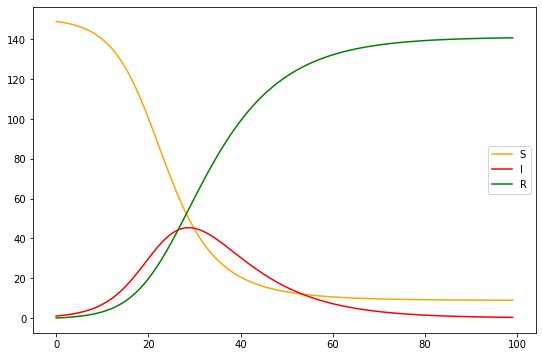

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
solution_df = pd.DataFrame(solution, columns = ["S","I","R"])
#设置不同人群的显示颜色，易感者为橘色，感染者为红色，恢复者为绿色
color_dict = {"S":"orange","I":"red","R":"green"} 
solution_df.plot(figsize=(9,6),color=[color_dict.get(x) for x in solution_df.columns])

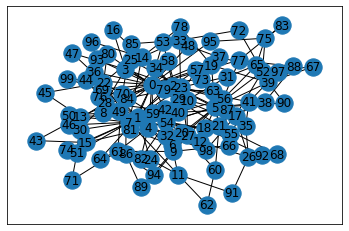

In [6]:
#生成100个节点的BA无标度网络
import warnings
warnings.filterwarnings("ignore")

import networkx as nx #导入NetworkX包，命名为nx
random_network = nx.barabasi_albert_graph(100,2) # 生成无标度网络，节点数和每个节点边数分别为100和2
#网络可视化
nx.draw_networkx(random_network,with_labels = True,pos = nx.spring_layout(random_network,seed = 1))

In [7]:
import random
# 根据 SIR 模型，更新节点的状态
def updateNodeState(G,node, beta, gamma):
    if G.nodes[node]["state"] == "I": #感染者
        p = random.random() # 生成一个0到1的随机数
        if p < gamma:   # gamma的概率恢复
            G.nodes[node]["state"] = "R" #将节点状态设置成“R”
    elif G.nodes[node]["state"] == "S": #易感者
        p = random.random() # 生成一个0到1的随机数
        k = 0  # 计算邻居中的感染者数量
        for neibor in G.adj[node]: # 查看所有邻居状态，遍历邻居用 G.adj[node]
            if G.nodes[neibor]["state"] == "I": #如果这个邻居是感染者，则k加1
                k = k + 1
        if p < 1 - (1 - beta)**k:  # 易感者被感染
            G.nodes[node]["state"] = "I"    

In [8]:
def updateNetworkState(G, beta, gamma):
    for node in G: #遍历图中节点，每一个节点状态进行更新
        updateNodeState(G,node, beta, gamma)

In [9]:
# 计算三类人群的数量
def countSIR(G):
    S = 0;I = 0
    for node in G:
        if G.nodes[node]["state"] == "S":
            S = S + 1
        elif G.nodes[node]["state"] == "I":
            I = I + 1
    return S,I, len(G.nodes) - S - I

In [10]:
def get_node_color(G): #返回每一个节点的颜色组成的列表
    color_list = []
    for node in G:
        #使用我们前面创建的状态到颜色的映射字典 color_dict 
        color_list.append(color_dict[G.nodes[node]["state"]])
    return color_list

In [11]:
ba = nx.barabasi_albert_graph(N,2,seed=seed) 
#初始化节点 state 属性
for node in ba:
    ba.nodes[node]["state"] = "S"
#随机选取一个节点为初始感染者  
ba.nodes[55]["state"] = "I" 

In [12]:
# 模拟天数为days，更新节点状态
import matplotlib.pyplot as plt
#fig,ax = plt.subplots(111)
%matplotlib inline
SIR_list = []
for t in range(0,days):
    updateNetworkState(ba,beta,gamma) #对网络状态进行模拟更新
    SIR_list.append(list(countSIR(ba))) #计算更新后三种节点的数量

<AxesSubplot:>

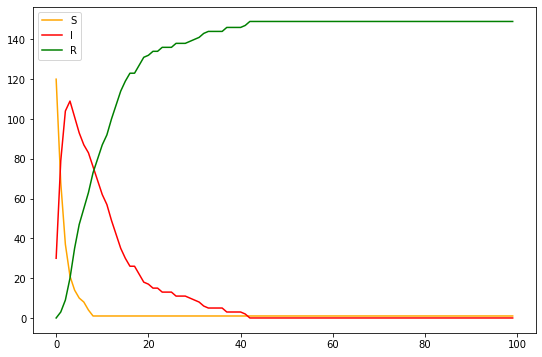

In [13]:
df = pd.DataFrame(SIR_list,columns=["S","I","R"])
df.plot(figsize=(9,6),color=[color_dict.get(x) for x in df.columns])

<AxesSubplot:>

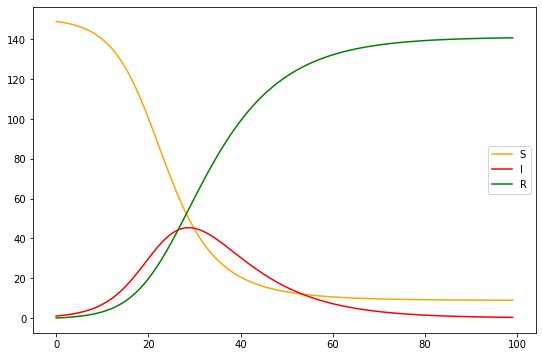

In [14]:
solution_df.plot(figsize=(9,6),color=[color_dict.get(x) for x in solution_df.columns])

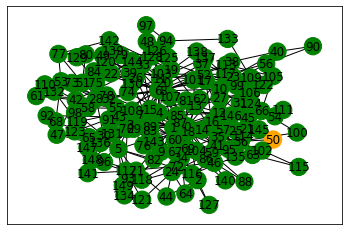

In [15]:
nx.draw_networkx(ba,with_labels = True, node_color = get_node_color(ba), pos = nx.spring_layout(ba,seed = 1))

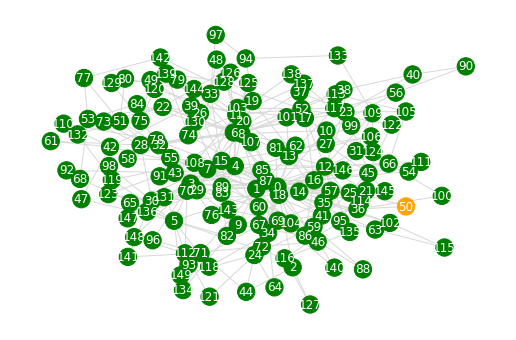

In [16]:
fig, ax = plt.subplots(figsize=(9, 6)) #将图的大小设置为 9×6
pos = nx.spring_layout(ba,seed = 1) #设置网络布局，将 seed 固定为 1
ax.axis("off") #关闭坐标轴
plt.box(False) #不显示方框
nx.draw(ba,with_labels = True,font_color="white",node_color = get_node_color(ba), edge_color = "#D8D8D8",pos = pos, ax=ax)

11


<AxesSubplot:>

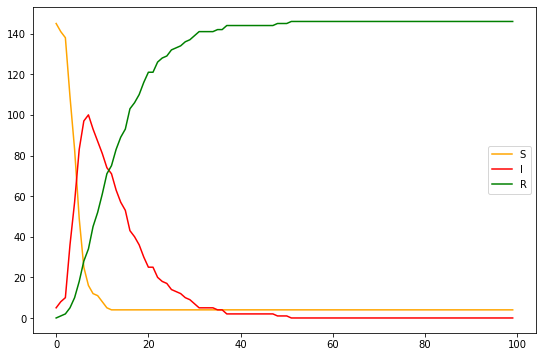

In [18]:
import numpy as np
seed_node = np.random.randint(0,N)
print(seed_node)
#初始化节点 state 属性
for node in ba:
    ba.nodes[node]["state"] = "S"
ba.nodes[seed_node]["state"] = "I"

# 模拟days天，更新节点状态
SIR_list = []
for t in range(0,days):
    updateNetworkState(ba,beta, gamma)
    SIR_list.append(list(countSIR(ba))) 
df = pd.DataFrame(SIR_list,columns=["S","I","R"])
df.plot(figsize=(9,6),color=[color_dict.get(x) for x in df.columns]) 

In [19]:
# 使用NetworkX的 degree_centrality 函数计算图中节点的度中心度
node_degree = nx.degree_centrality(ba)

node_degree_df = pd.DataFrame.from_dict(node_degree, orient = "index", columns=["degree"])
node_degree_df = node_degree_df.reset_index().rename(columns = {"index":"node"})

#查看度数最高的节点
node_degree_df.sort_values(by = "degree",inplace = True,ascending= False)
node_degree_df.head()

,node,degree
0,0,0.221477
6,6,0.120805
3,3,0.107383
1,1,0.093960
12,12,0.093960


0


<AxesSubplot:>

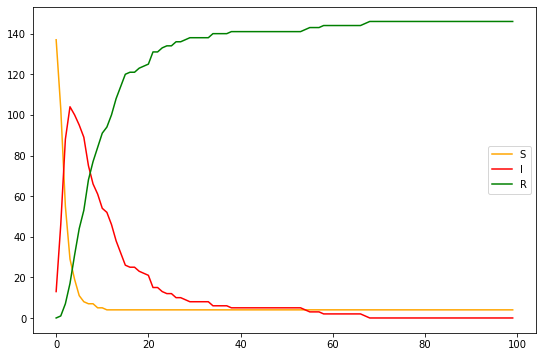

In [20]:
seed_node = int(node_degree_df.values[0,0])
print(seed_node)
#初始化节点 state 属性
for node in ba:
    ba.nodes[node]["state"] = "S"
ba.nodes[seed_node]["state"] = "I"

# 模拟days天，更新节点状态
SIR_list = []
for t in range(0,days):
    updateNetworkState(ba,beta, gamma)
    SIR_list.append(list(countSIR(ba))) 
df = pd.DataFrame(SIR_list,columns=["S","I","R"])
df.plot(figsize=(9,6),color=[color_dict.get(x) for x in df.columns])  